# Imbalanced datasets
------------------------------------

This example shows how to handle imbalanced datasets using ATOM's branch system to evaluate differrent pipelines.

## Load the data

In [1]:
# Import packages
from atom import ATOMClassifier
from sklearn.datasets import make_classification

In [2]:
# Create a mock imbalanced dataset
X, y = make_classification(n_samples=10000, weights=(0.95,), random_state=1)

## Run the pipeline

In [3]:
# Initialize ATOM with the created dataset
atom = ATOMClassifier(X, y, test_size=0.2, verbose=2, random_state=1)

<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ====================== >>
Shape: (10000, 21)
Scaled: True
Outlier values: 1090 (0.6%)
---------------------------------------
Train set size: 8000
Test set size: 2000
---------------------------------------
|    | dataset     | train       | test        |
|---:|:------------|:------------|:------------|
|  0 | 9445 (17.0) | 7551 (16.8) | 1894 (17.9) |
|  1 | 555 (1.0)   | 449 (1.0)   | 106 (1.0)   |



In [4]:
# Have a look at the data, note that atom automatically
# names the columns if the input is not a dataframe
atom.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Target
0,-0.071428,0.310280,-1.196560,-1.529671,-1.173725,-0.254356,0.701712,-1.411579,-0.704537,-0.088643,...,0.074736,0.643117,-1.154644,0.536625,1.009980,-1.375527,0.917017,-1.802224,-0.162823,0
1,-0.516592,0.530945,1.661092,-1.292453,-0.141586,-0.664244,-1.071332,1.374610,-1.313380,0.828266,...,-0.836718,0.116314,-2.116304,0.551715,0.765546,-0.036432,-1.015412,1.062622,-0.387390,0
2,-0.088401,0.427176,0.909883,0.004638,0.394158,0.449127,-0.505026,0.159599,0.365104,0.482750,...,-2.318417,-0.532931,-1.063758,0.275730,-0.729440,2.046880,-0.145395,-0.200415,0.207975,0
3,-0.100931,-0.994237,1.972203,0.294235,-0.676401,0.824231,1.829958,0.255509,0.021049,-0.143176,...,0.575833,-0.366357,-2.027100,-0.814381,-0.388433,2.608870,0.233957,0.940194,-0.341405,0
4,-0.010847,-1.071147,0.519265,-0.705204,0.571365,0.259026,0.318726,-0.396639,-0.560105,1.031218,...,0.688116,-1.098997,0.391576,1.447618,-0.858905,-0.991063,-0.308652,0.659853,-0.810452,0


In [5]:
# Let's start reducing the number of features
atom.feature_selection("RFE", solver="RF", n_features=12)

Fitting FeatureSelector...
Performing feature selection ...
 --> The RFE selected 12 features from the dataset.
   >>> Dropping feature Feature 1 (rank 6).
   >>> Dropping feature Feature 5 (rank 7).
   >>> Dropping feature Feature 10 (rank 5).
   >>> Dropping feature Feature 12 (rank 3).
   >>> Dropping feature Feature 17 (rank 9).
   >>> Dropping feature Feature 18 (rank 8).
   >>> Dropping feature Feature 19 (rank 4).
   >>> Dropping feature Feature 20 (rank 2).


In [6]:
# Now, we fit a SVM model directly on the imbalanced data
atom.run("RF", metric="ap")


Training ===================================== >>
Models: RF
Metric: average_precision


Results for Random Forest:         
Fit ---------------------------------------------
Train evaluation --> average_precision: 1.0
Test evaluation --> average_precision: 0.8384
Time elapsed: 2.065s
-------------------------------------------------
Total time: 2.065s


Final results ========================= >>
Duration: 2.065s
------------------------------------------
Random Forest --> average_precision: 0.8384


In [7]:
# The transformer and the models have been added to the branch
atom.branch

Branch: master
 --> Pipeline: 
   >>> FeatureSelector
     --> strategy: RFE
     --> solver: RandomForestClassifier(n_jobs=1, random_state=1)
     --> n_features: 12
     --> max_frac_repeated: 1.0
     --> max_correlation: 1.0
     --> kwargs: {}
 --> Models: RF

## Oversampling

In [8]:
# Create a new branch for oversampling
atom.branch = "oversample"

New branch oversample successfully created!


In [9]:
atom.branch  # The branch adopts all transformers from the parent branch

Branch: oversample
 --> Pipeline: 
   >>> FeatureSelector
     --> strategy: RFE
     --> solver: RandomForestClassifier(n_jobs=1, random_state=1)
     --> n_features: 12
     --> max_frac_repeated: 1.0
     --> max_correlation: 1.0
     --> kwargs: {}
 --> Models: None

In [10]:
# Perform oversampling of the minority class
atom.balance(strategy="smote")

Oversampling with SMOTE...
 --> Adding 7102 samples to class: 1.


In [11]:
atom.classes  # Check the balanced training set!

,dataset,train,test
0,9445,7551,1894
1,7657,7551,106


In [12]:
# Train another SVM model on this branch
atom.run("rf_os")


Training ===================================== >>
Models: RF_os
Metric: average_precision


Results for Random Forest:         
Fit ---------------------------------------------
Train evaluation --> average_precision: 1.0
Test evaluation --> average_precision: 0.8423
Time elapsed: 2.719s
-------------------------------------------------
Total time: 2.719s


Final results ========================= >>
Duration: 2.719s
------------------------------------------
Random Forest --> average_precision: 0.8423


## Undersampling

In [13]:
# Create the undersampling branch
# Create from master to not adopt the SMOTE transformer!
atom.branch = "undersample_from_master"

New branch undersample successfully created!


In [14]:
atom.master

Branch: master
 --> Pipeline: 
   >>> FeatureSelector
     --> strategy: RFE
     --> solver: RandomForestClassifier(n_jobs=1, random_state=1)
     --> n_features: 12
     --> max_frac_repeated: 1.0
     --> max_correlation: 1.0
     --> kwargs: {}
 --> Models: RF

In [15]:
atom.classes  # In this branch, the data is still imbalanced

,dataset,train,test
0,9445,7551,1894
1,555,449,106


In [16]:
# Perform undersampling of the majority class
atom.balance(strategy="NearMiss")

Undersampling with NearMiss...
 --> Removing 7102 samples from class: 0.


In [17]:
atom.run("rf_us")


Training ===================================== >>
Models: RF_us
Metric: average_precision


Results for Random Forest:         
Fit ---------------------------------------------
Train evaluation --> average_precision: 1.0
Test evaluation --> average_precision: 0.7779
Time elapsed: 0.241s
-------------------------------------------------
Total time: 0.241s


Final results ========================= >>
Duration: 0.241s
------------------------------------------
Random Forest --> average_precision: 0.7779 ~


## Analyze results

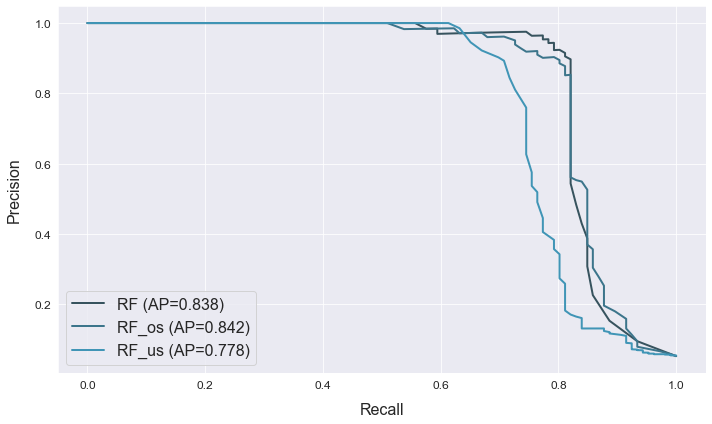

In [18]:
atom.plot_prc()

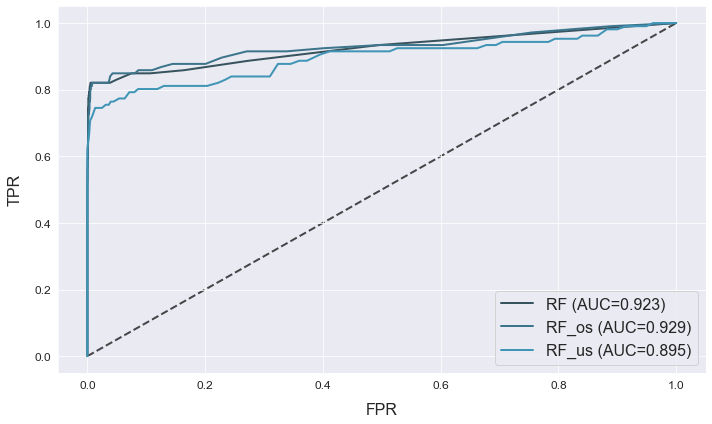

In [19]:
atom.plot_roc()

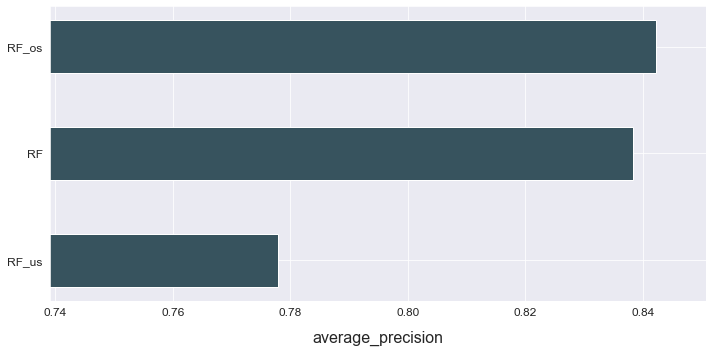

In [20]:
# Comparing the performances of all the SVM models can now easily
# be done through atom
atom.plot_results()

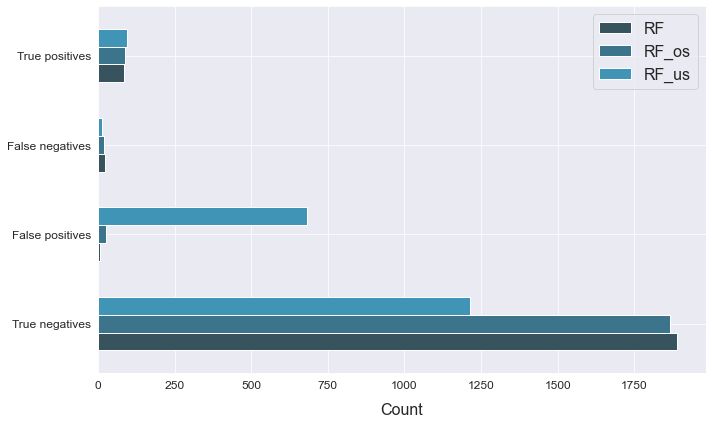

In [21]:
atom.plot_confusion_matrix()